In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import wrds
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
from scipy import stats
import janitor 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

import statsmodels.api as sm

In [3]:
data = pd.read_pickle("data99.pkl")

In [6]:
data00 = data.copy()

In [8]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

def calculate_portfolio_returns(data, portfolios,var,weight):
    result = pd.DataFrame()

    for portfolio in portfolios:
        subset = data[data[portfolio] == 1]
        result[portfolio] = subset.groupby('jdate').apply(wavg, var, weight)
    result['all_vwret'] = data.groupby('jdate').apply(wavg, var, weight)

    for portfolio in portfolios:
        result[portfolio + '_excess'] = result[portfolio] - result['all_vwret']

    portfolio_return = result.reset_index()
    return portfolio_return

portfolios = ['MV', 'BV', 'SV', 'MG', 'BG', 'SG']

portfolio_beme = calculate_portfolio_returns(data00,portfolios,'beme','me')

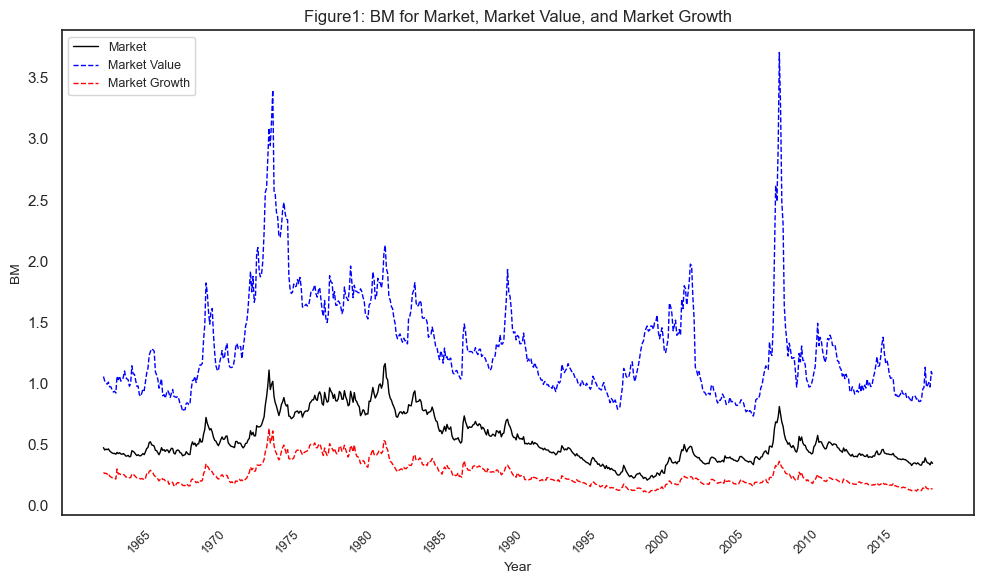

In [ ]:
######### Figure 1 #########

sns.set(style="white", font_scale=1)
plt.figure(figsize=(10, 6))
sns.lineplot(x='jdate', y='all_vwret', data=portfolio_beme, label='Market', color='black', linewidth=1, linestyle='-')
sns.lineplot(x='jdate', y='MV', data=portfolio_beme, label='Market Value', color='blue', linewidth=1, linestyle='--')
sns.lineplot(x='jdate', y='MG', data=portfolio_beme, label='Market Growth', color='red', linewidth=1, linestyle='--')
plt.title('Figure1: BM for Market, Market Value, and Market Growth', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('BM', fontsize=10)
plt.legend(loc='upper left', fontsize=9)
start_year = 1965
end_year = portfolio_beme['jdate'].dt.year.max()
years = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='5Y')
plt.xticks(years, years.year, rotation=45, fontsize=9)
plt.tight_layout()
plt.show()

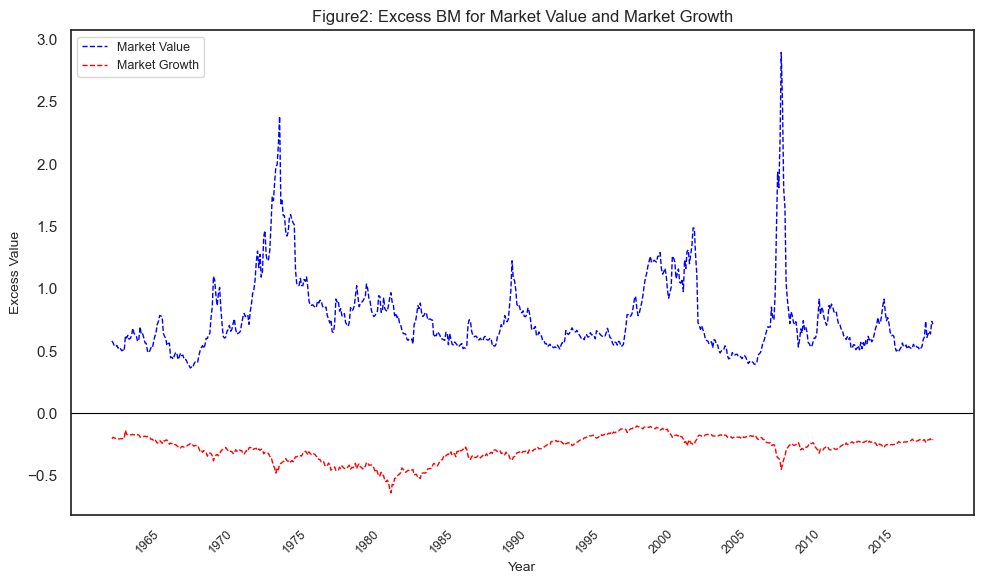

In [15]:
######### Figure 2 #########

sns.set(style="white", font_scale=1)
plt.figure(figsize=(10, 6))
plt.plot(portfolio_beme['jdate'], portfolio_beme['MV_excess'], label='Market Value', color='blue', linestyle='--', linewidth=1)
plt.plot(portfolio_beme['jdate'], portfolio_beme['MG_excess'], label='Market Growth', color='red', linestyle='--', linewidth=1)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.title('Figure2: Excess BM for Market Value and Market Growth', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Excess Value', fontsize=10)
plt.legend(loc='upper left', fontsize=9)
start_year = 1965
end_year = portfolio_beme['jdate'].dt.year.max()
years = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='5Y')
plt.xticks(years, years.year, rotation=45, fontsize=9)
plt.tight_layout()
plt.show()

In [ ]:
data = pd.read_pickle("data99.pkl")

In [16]:
def summary(data, portfolio):
    portfolio_name = portfolio + '_excess'
    _data00 = data[portfolio_name]
    _data00 = _data00

    mean = _data00.mean()  
    var = _data00.var(ddof=1)  
    sd = var ** 0.5  
    n = len(_data00)  
    se = (var / n) ** 0.5 
    t_stat_diff = mean / se 

    result = pd.DataFrame(
        [
            mean ,  
            sd ,   
            t_stat_diff  
        ],
        index=['Average Excess Return', 'Standard Deviation', 't-Statistic'],
        columns=[portfolio]
    )

    return result

In [17]:
portfolio_beme00 = portfolio_beme.copy()
portfolio_beme00['post_dummy'] = (portfolio_beme00['jdate'] <= '1991-06-30').astype(int)
subset = portfolio_beme00.copy()
subset00 = portfolio_beme00[portfolio_beme00['post_dummy']==1].reset_index(drop=True)
subset11 = portfolio_beme00[portfolio_beme00['post_dummy']==0].reset_index(drop=True)
subset99 = subset00 - subset11

In [129]:
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan


def calculate_statistics(dataset,portfolios,variable,weight):
    result = pd.DataFrame()

    for portfolio in portfolios:
        subset = dataset[dataset[portfolio] == 1]
        result[portfolio] = subset.groupby('jdate').apply(lambda x: wavg(x, variable, weight))
    
    result['all_vwret'] = dataset.groupby('jdate').apply(lambda x: wavg(x, variable, weight))

    for portfolio in portfolios:
        result[portfolio + '_excess'] = result[portfolio] - result['all_vwret']

    excess_returns = result[[portfolio + '_excess' for portfolio in portfolios]]
    mean_excess_returns = excess_returns.mean()
    std_deviation = excess_returns.std()   
    # t_statistic = mean_excess_returns / (std_deviation / np.sqrt(excess_returns.count()))

    final_result = pd.DataFrame(
        [
            mean_excess_returns.values,  
            std_deviation.values ,      
            # t_statistic.values              
        ],
        index=['Average Excess Beme', 'Standard Deviation'],
        columns=portfolios
    )
    return final_result.round(2), result

portfolios = ['MV', 'BV', 'SV', 'MG', 'BG', 'SG']

In [18]:
result00 = pd.concat(
    [summary(subset, portfolio=portfolio) for portfolio in portfolios], 
    axis=1
).round(2)

result11 = pd.concat(
    [summary(subset00, portfolio=portfolio) for portfolio in portfolios], 
    axis=1
).round(2)

result22 = pd.concat(
    [summary(subset11, portfolio=portfolio) for portfolio in portfolios], 
    axis=1
).round(2)

result33 = pd.concat(
    [summary(subset99, portfolio=portfolio) for portfolio in portfolios], 
    axis=1
).round(2)

table1_panelA = pd.concat([result00,result11,result22,result33], axis=0)
table1_panelA

,MV,BV,SV,MG,BG,SG
Average Excess Return,0.76,0.72,0.95,-0.28,-0.28,-0.27
Standard Deviation,0.31,0.28,0.39,0.10,0.10,0.12
t-Statistic,64.10,67.43,62.11,-72.60,-73.81,-59.31
Average Excess Return,0.79,0.75,0.97,-0.34,-0.34,-0.33
Standard Deviation,0.31,0.28,0.35,0.09,0.09,0.13
t-Statistic,47.26,48.66,51.40,-66.94,-68.88,-47.01
Average Excess Return,0.73,0.69,0.92,-0.22,-0.22,-0.21
Standard Deviation,0.31,0.27,0.44,0.06,0.06,0.06
t-Statistic,43.71,47.08,38.62,-70.57,-70.69,-60.26
Average Excess Return,0.06,0.05,0.05,-0.13,-0.12,-0.12


In [19]:
variables = ['all_vwret', 'MV', 'MG', 'SV', 'SG', 'BV', 'BG']
subset = portfolio_beme00[variables]
corr_matrix = subset.corr()
corr_matrix00 = pd.DataFrame(corr_matrix.iloc[0, 1:].round(2)).T

variables = ['MV_excess', 'MG_excess', 'SV_excess', 'SG_excess', 'BV_excess', 'BG_excess']
subset = portfolio_beme00[variables]
corr_matrix11 = subset.corr().round(2)
corr_matrix11.columns = corr_matrix11.columns.str.replace('_excess', '')
corr_matrix11.index = corr_matrix11.index.str.replace('_excess', '')

corr_matrix = pd.concat([corr_matrix00, corr_matrix11])
corr_matrix.index.values[0] = 'Cor(R, RM)'

In [20]:
table2_panelB = corr_matrix
print(table2_panelB)

              MV    MG    SV    SG    BV    BG
Cor(R, RM)  0.73  0.96  0.66  0.83  0.77  0.96
MV          1.00 -0.28  0.96 -0.06  1.00 -0.30
MG         -0.28  1.00 -0.27  0.93 -0.31  1.00
SV          0.96 -0.27  1.00 -0.06  0.94 -0.28
SG         -0.06  0.93 -0.06  1.00 -0.09  0.92
BV          1.00 -0.31  0.94 -0.09  1.00 -0.32
BG         -0.30  1.00 -0.28  0.92 -0.32  1.00


In [ ]:
def autocorrelations(data, columns, max_lag=12):
    autocorr_df = pd.DataFrame(index=range(1, max_lag + 1), columns=columns)
    
    for col in columns:
        for lag in range(1, max_lag + 1):
            autocorr_df.loc[lag, col] = data[col].shift(lag).corr(data[col])
    
    return autocorr_df
columns = ['MV', 'BV', 'SV', 'MG', 'BG', 'SG']
autocorr_result = autocorrelations(portfolio_beme00, columns)
autocorr_result = autocorr_result.apply(pd.to_numeric, errors='coerce')
table2_panelC = autocorr_result.round(2)
print(table2_panelC)


      MV    BV    SV    MG    BG    SG
1   0.97  0.97  0.96  0.98  0.98  0.98
2   0.92  0.92  0.91  0.96  0.96  0.95
3   0.87  0.88  0.85  0.94  0.94  0.93
4   0.82  0.83  0.79  0.92  0.92  0.90
5   0.77  0.78  0.73  0.90  0.90  0.87
6   0.72  0.73  0.67  0.88  0.88  0.85
7   0.68  0.69  0.63  0.87  0.87  0.83
8   0.65  0.66  0.60  0.86  0.87  0.82
9   0.63  0.64  0.58  0.85  0.86  0.81
10  0.60  0.61  0.55  0.85  0.85  0.80
11  0.58  0.59  0.53  0.84  0.85  0.79
12  0.56  0.57  0.51  0.84  0.84  0.78


In [30]:
portfolio_beme.to_pickle('portfolio_beme.pkl')